In [1]:
import torch
from matplotlib.pyplot import xlabel, yscale, xscale
from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random

In [2]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)

In [3]:
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))

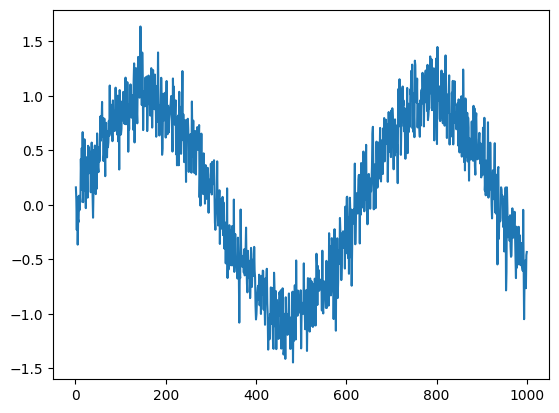

In [4]:
plt.plot(time, x)

In [5]:
tau=4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T-tau+i]
labels=x[tau:].reshape(-1,1)


batch_size=16
n_train=600

In [6]:
def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential=nn.Sequential(
            nn.Linear(4, 10)
            ,nn.ReLU()
            ,nn.Linear(10, 1))
        self.sequential.apply(init_weights)
    def forward(self,x):
        return self.sequential(x)

In [7]:
class TimeDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data            # 数据路径或数据本身
        self.labels = labels         # 标签
        self.transform = transform  # 数据预处理（如transforms.Compose）

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [8]:
data=TimeDataset(features[:600], labels[:600])
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
loss=nn.MSELoss(reduction='none')

In [9]:
def train(model, train_iter, loss, epoch, lr):
    trainer=torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epoch):
        for x,y in train_iter:
            trainer.zero_grad()
            y_hat=model(x)
            l=loss(y_hat, y)
            l.sum().backward()
            trainer.step()
        
        loss_eval=0
        for x,y in train_iter:
            loss_eval+=loss(model(x), y).sum()
        
        print(f'epoch {epoch + 1}, '
              f'loss: {loss_eval})')
    

In [10]:
net=Net()

In [11]:
train(net,dataloader,loss,5,lr=0.01)

epoch 1, loss: 36.828651428222656)
epoch 2, loss: 30.530075073242188)
epoch 3, loss: 29.584558486938477)
epoch 4, loss: 30.413564682006836)
epoch 5, loss: 30.99237060546875)


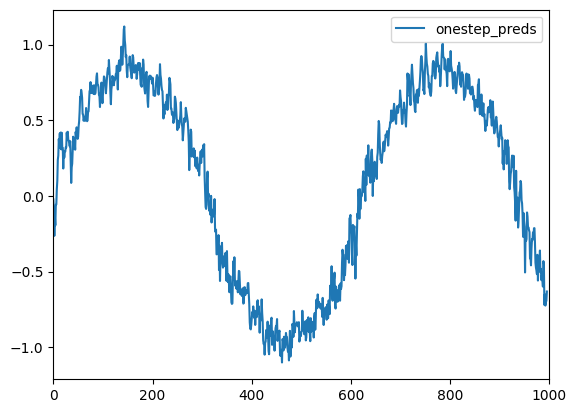

In [12]:
plt.plot(net(features).detach().numpy())
plt.legend(['onestep_preds'])
plt.xlim([0,1000])
plt.show()

In [13]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

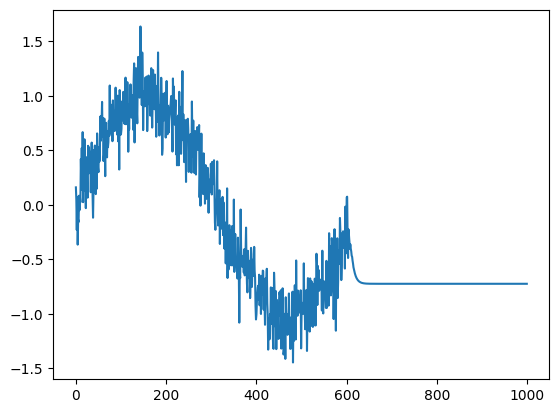

In [14]:
plt.plot(multistep_preds.detach().numpy())
##这个地方出错是正常的

In [15]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是第（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

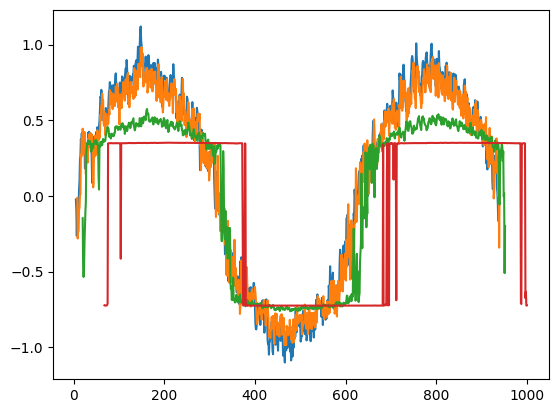

In [16]:
steps = (1, 4, 16, 64)
for i in steps:
    plt.plot(time[tau + i - 1: T - max_steps + i].detach().numpy(),
             features[:, (tau + i - 1)].detach().numpy())

In [17]:
import collections
import re
import requests
import matplotlib.pyplot as plt
import random 

In [18]:
def read_time_machine():
    DATA_HUB = dict()
    DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

    DATA_HUB['time_machine'] = ('http://d2l-data.s3-accelerate.amazonaws.com/'+ 'timemachine.txt',
                                    '090b5e7e70c295757f55df93cb0a180b9691891a')

    r = requests.get(DATA_HUB['time_machine'][0], stream=True, verify=True)

    f=open('../data/time_machine.txt', 'wb')
    f.write(r.content)
    f.close()

    with open('../data/time_machine.txt', 'r',encoding='utf-8') as f:
        lines=f.readlines()
        result=[re.sub('[^A-Za-z]', ' ', line).strip().lower() for line in lines]
    return result

# 词元化

In [19]:
def tokenize(text,token='word'):
    if token == 'word':
        return [i.split() for i in text]
    if token == 'char':
        return [list(line) for line in text]
    else:
        print('wrong token')

def count_corpus(tokens):
    '''统计词元频率'''
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

## 词表
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        self.tokens=tokens
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0,如果有其他的特殊标记词 则unk放在其他词前面
        self.idx_to_token = ['<unk>'] + reserved_tokens
        # 整理标记词的token to idx
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        
        # 整理所有满足条件的词
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
        
    def __len__(self):
        return len(self.token_to_idx)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
                return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs
    
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

In [20]:


corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(174735, 28)

In [21]:
vocab.token_to_idx

{'<unk>': 0,
 ' ': 1,
 'e': 2,
 't': 3,
 'a': 4,
 'i': 5,
 'n': 6,
 'o': 7,
 's': 8,
 'h': 9,
 'r': 10,
 'd': 11,
 'l': 12,
 'm': 13,
 'u': 14,
 'c': 15,
 'f': 16,
 'w': 17,
 'g': 18,
 'y': 19,
 'p': 20,
 'b': 21,
 'v': 22,
 'k': 23,
 'x': 24,
 'z': 25,
 'j': 26,
 'q': 27}

In [22]:
###二元词
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs
freq2=[j for i,j in bigram_vocab.token_freqs]

In [23]:
###三元词
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[((1, 3, 9), 3629),
 ((3, 9, 2), 3127),
 ((9, 2, 1), 2205),
 ((6, 11, 1), 1483),
 ((4, 6, 11), 1399),
 ((1, 4, 6), 1368),
 ((2, 11, 1), 1352),
 ((1, 7, 16), 1126),
 ((5, 6, 18), 1101),
 ((1, 5, 1), 1075)]

下面的代码每次可以从数据中随机生成一个小批量。 在这里，参数batch_size指定了每个小批量中子序列样本的数目， 参数num_steps是每个子序列中预定义的时间步数。

In [24]:
def seq_data_iter_random(corpus,batch_size,num_steps):
    """使用随机抽样生成一个小批量子序列"""
    ## 随机一个初始位置 对序列分区，随即范围<=num_steps
    corpus=corpus[random.randint(0,num_steps-1):]
    ## 能够分出的子序列个数
    num_subseqs=(len(corpus)-1)//num_steps
    ## 每一个长度为子序列起始索引
    initial_indices=list(range(0,num_subseqs*num_steps,num_steps))
    ## 打乱
    random.shuffle(initial_indices)
    # 
    # def data(pos):
    #     return corpus[pos,pos+num_steps]
    
    num_batches=num_subseqs//batch_size
    for i in range(0,num_batches*batch_size,batch_size):
        initial_indices_per_batch=initial_indices[i:i+batch_size]
        x=[corpus[i:i+num_steps] for i in initial_indices_per_batch]
        y=[corpus[i+1:i+1+num_steps] for i in initial_indices_per_batch]
        yield torch.tensor(x),torch.tensor(y)
        


In [25]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[12, 13, 14, 15, 16],
        [ 7,  8,  9, 10, 11]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [ 8,  9, 10, 11, 12]])
X:  tensor([[ 2,  3,  4,  5,  6],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [28, 29, 30, 31, 32]])
X:  tensor([[17, 18, 19, 20, 21],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[18, 19, 20, 21, 22],
        [23, 24, 25, 26, 27]])


## 顺序分区

In [26]:
def seq_data_iter_sequential(corpus,batch_size,num_steps):
    offset=random.randint(0,num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    ## 把x展平 按照batch_size 拆为按照batch_size行 
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    ## 然后把每个batchsize 按照num_steps 继续拆分
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [27]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn=seq_data_iter_random
        else:
            self.data_iter_fn=seq_data_iter_sequential
        self.corpus,self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size,self.num_steps = batch_size,num_steps
        
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [28]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [29]:
s=SeqDataLoader(batch_size=10,num_steps=5,use_random_iter=False,max_tokens=10000)

# 循环神经网络

In [30]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
import sys
sys.path.append('../')
from utils.useful_func import *

batch_size, num_steps = 32, 35
##train_iter 返回的是每个字母的索引
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [31]:
## 将每个索引映射为相互不同的单位向量
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28)

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [32]:
# 初始化模型参数
def get_params(vocab_size,num_hiddens,device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape,device=device)*0.01
    ## 隐藏层参数
    W_xh=normal((num_inputs,num_hiddens))
    W_hh=normal((num_hiddens,num_hiddens))
    b_h=torch.zeros(num_hiddens,device=device)
    W_hq=normal((num_hiddens,num_outputs))
    b_q=torch.zeros(num_outputs,device=device)
    params=[W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [33]:
def init_rnn_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size, num_hiddens),device=device),)

In [34]:
type((1))

int

In [35]:
def rnn(inputs, state,params):
    [W_xh,W_hh,b_h,W_hq,b_q]=params
    H,=state
    outputs=[]
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0),(H,)

In [36]:
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device,
                    get_params,init_state,forward_fn
                 ):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size,num_hiddens,device)
        self.init_state, self.forward_fn = init_state,forward_fn

    def __call__(self, inputs, state):
        #转置的目的是 为了能够直接通过最外层的维度直接循环 以训练序列数据
        X=F.one_hot(inputs.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state,self.params)
    
    def begin_state(self, batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)


In [37]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [38]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [39]:
F.one_hot(X.T, 28)

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [40]:
net = RNNModelScratch(len(vocab), 512, 'cpu', get_params,init_rnn_state, rnn)

In [41]:
state = net.begin_state(X.shape[0], 'cpu')

In [42]:
Y, new_state = net(X, state)

In [43]:
#输出形状是（时间步数批量大小，词表大小）， 而隐状态形状保持不变，即（批量大小，隐藏单元数）。
Y.shape,new_state

(torch.Size([10, 28]),
 (tensor([[ 0.0045, -0.0074, -0.0047,  ..., -0.0122, -0.0013,  0.0135],
          [-0.0089,  0.0079,  0.0088,  ...,  0.0043,  0.0049,  0.0082]],
         grad_fn=<TanhBackward0>),))

In [44]:
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    norm=torch.sqrt(torch.sum(torch.tensor([torch.sum(p.grad**2) for p in params])))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [45]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent.

    Defined in :numref:`sec_utils`"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [46]:
loss = nn.CrossEntropyLoss()
updater = lambda batch_size: sgd(net.params, lr, batch_size)

In [47]:
train_epoch_ch8(net,train_iter,loss,updater,'cpu',use_random_iter=False)

NameError: name 'train_epoch_ch8' is not defined

In [121]:
net.begin_state(batch_size=X.shape[0], device='cpu')

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),)

In [48]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, Timer()
    metric = Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 初始化状态
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            # 非原地分离状态
            if isinstance(net, nn.Module):
                if isinstance(state, tuple):
                    # LSTM状态：分离每个张量
                    state = tuple(s.detach() for s in state)
                else:
                    # GRU状态：直接分离
                    state = state.detach()
            else:
                # 自定义模型状态处理
                state = (s.detach() for s in state)
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()


In [49]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()

    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

In [52]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, 'cpu')

time traveller  moned along thist ow they time   atter  and they
time traveller  mone mave at elant bove ar  wald a dof the ingra
time traveller  ald and aldint upalex thather asmallyoreemp real
time traveller  with a sorle  the hall rave tha dore matter dime
time traveller  ald bed wo she wirklyou   said filby   but you a
time traveller  with a slang of the inst hislldot i jersan gho t
time traveller  ald bat for as so  athen thes aran    meated  is
time traveller  wo mines along the time dimension woor aneatore 
time traveller  with a slaghe thr endin the plyche of spack  and
time traveller smoled l  germed  follin  inar  atine the rous  a
time traveller  after the time traveller  after the time travell
time traveller  wote oustlo smutwonke siftweytre sofe the  a med
time traveller smiled roun  at us  ainntous mat rathar as how   
time traveller  mod in  fou tod cave thes alaimed t is aling thi
time traveller  midef ree panons ou the nnoml gutt wistelbais to
time traveller  after the

In [56]:
predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, 'cpu')

In [66]:
predict('are ')

'are whing  but sait a moment  can an  instantaneouscub'

In [67]:
read_time_machine()

['the time machine  by h  g  wells',
 '',
 '',
 '',
 '',
 'i',
 '',
 '',
 'the time traveller  for so it will be convenient to speak of him',
 'was expounding a recondite matter to us  his grey eyes shone and',
 'twinkled  and his usually pale face was flushed and animated  the',
 'fire burned brightly  and the soft radiance of the incandescent',
 'lights in the lilies of silver caught the bubbles that flashed and',
 'passed in our glasses  our chairs  being his patents  embraced and',
 'caressed us rather than submitted to be sat upon  and there was that',
 'luxurious after dinner atmosphere when thought roams gracefully',
 'free of the trammels of precision  and he put it to us in this',
 'way  marking the points with a lean forefinger  as we sat and lazily',
 'admired his earnestness over this new paradox  as we thought it',
 'and his fecundity',
 '',
 'you must follow me carefully  i shall have to controvert one or two',
 'ideas that are almost universally accepted  the geometry  f